# **Part 2 | Multi-Factor Analysis**
*An Analysis of Fama and French 5 Faktor Model with Momentum and ESG Factor*

In [1]:
#General Imports
import pandas as pd
import numpy as np
import os
import warnings

#Plotting
from matplotlib.ticker import FuncFormatter, PercentFormatter
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, DateFormatter
from matplotlib import cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

#Working with Data
from functools import reduce #Get Monthly Data
from datetime import datetime, timedelta
import datetime as dt
from pandas.tseries.offsets import MonthEnd

#Estimation
import statsmodels.api as sm #Regression
from scipy import stats #Correlation
from scipy.stats import kendalltau, spearmanr #Kendal Tau

#Other Stuff
from IPython.display import display, Markdown  # For Markdown rendering

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

## **1. Data Collection**

### **1.1 Import ESG Data**

In [10]:
esg_data = pd.read_csv("__data/return_history.csv", delimiter = ",") #Importing ESG Factor Data

In [11]:
esg_data_subsetted = esg_data.rename(columns={"Average_Return_High": "return_high_esg", "Average_Return_Low": "return_low_esg"})
esg_data_subsetted = esg_data_subsetted[["Date", "return_high_esg", "return_low_esg", "ESG_Factor"]]

esg_data_subsetted["Date"] = pd.to_datetime(esg_data["Date"])
esg_data_subsetted['Date'] = esg_data_subsetted["Date"].dt.date

In [12]:
esg_data.tail()

,Date,Average_Return_High,Count_High,Average_Return_Low,Count_Low,ESG_Factor
263,2023-12-31,0.083022,373,0.115144,373,0.032122
264,2024-01-31,-0.018097,373,-0.037933,373,-0.019836
265,2024-02-29,0.031722,373,0.045612,373,0.013890
266,2024-03-31,0.046259,373,0.027716,373,-0.018543
267,2024-04-30,-0.047620,373,-0.065576,373,-0.017956


### **1.2 Importing Single Stock Data**

In [16]:
#Imports Stock Returns
stock_returns = pd.read_excel("__data/Stock_Data_Wide_Format.xlsx", "ReturnTotal")

In [17]:
#Divides Stock Return values by 100 to get decimal values
stock_returns.loc[:, stock_returns.columns != "Date"] = stock_returns.loc[:, stock_returns.columns != "Date"].apply(lambda x: x / 100)

In [18]:
stock_returns["Date"] = pd.to_datetime(stock_returns["Date"])

In [19]:
stock_returns.tail()

,Date,A.N,AA.N,AAL.OQ,AAON.OQ,AAP.N,AAPL.OQ,AAT.N,ABBV.N,ABCB.N,...,YETI.N,YOU.N,YUM.N,ZBH.N,ZBRA.OQ,ZD.OQ,ZI.OQ,ZION.OQ,ZTS.N,ZWS.N
185,2024-06-30,-0.005981,-0.101423,-0.014783,0.163717,-0.103482,0.095553,0.044880,0.063756,0.011011,...,-0.063574,0.113823,-0.036164,-0.055398,-0.010918,-0.044437,0.039902,0.004168,0.022411,-0.061003
186,2024-07-31,0.092844,-0.169432,-0.060900,0.014787,0.003973,0.054411,0.184987,0.090424,0.239588,...,0.083879,0.141101,0.002793,0.025984,0.136795,-0.130245,-0.110415,0.191377,0.041036,0.104082
187,2024-08-31,0.010750,-0.025335,-0.001880,0.078843,-0.284541,0.032345,0.027526,0.059303,0.012153,...,-0.024909,0.423419,0.020794,0.036911,-0.016544,0.020677,-0.129401,-0.032311,0.019162,0.001645
188,2024-09-30,0.038903,0.201869,0.058380,0.130130,-0.139484,0.017467,-0.006791,0.005960,0.014766,...,0.017609,0.094090,0.035503,-0.062966,0.072210,-0.004297,0.043478,-0.047215,0.064799,0.108233
189,2024-10-31,-0.120960,0.041676,0.192171,0.059162,-0.078540,-0.030429,0.008608,0.040698,-0.006411,...,-0.141847,0.109837,-0.061198,-0.009541,0.031459,-0.049116,0.070736,0.102499,-0.082752,0.004452


### **1.3 Importing Momentum Factor Data**

In [2]:
def prepMomentumData(data, suffix):

  data_adj = data.copy()

  data_adj["date"] = pd.to_datetime(data_adj["date"], errors='coerce')
  data_adj["date"] = data_adj["date"].dt.date

  data_adj = data_adj.rename(columns={'date': 'Date'})
  data_adj = data_adj.rename(columns={'ret': f"Mom_{suffix}_Factor"})

  data_adj = data_adj[["Date", f"Mom_{suffix}_Factor"]]

  return data_adj

In [7]:
#Importing Residual Momentum Data
res_mom_12_1 = pd.read_csv('__data/[usa]_[resff3_12_1]_[monthly]_[ew].csv', delimiter = ",")
res_mom_6_1 = pd.read_csv('__data/[usa]_[resff3_6_1]_[monthly]_[ew].csv', delimiter = ",")

#Importing Price Momentum Data
price_mom_3_1 = pd.read_csv('__data/[usa]_[ret_3_1]_[monthly]_[ew].csv', delimiter = ",")
price_mom_6_1 = pd.read_csv('__data/[usa]_[ret_6_1]_[monthly]_[ew].csv', delimiter = ",")
price_mom_9_1 = pd.read_csv('__data/[usa]_[ret_9_1]_[monthly]_[ew].csv', delimiter = ",")
price_mom_12_1 = pd.read_csv('__data/[usa]_[ret_12_1]_[monthly]_[ew].csv', delimiter = ",")
price_mom_12_7 = pd.read_csv('__data/[usa]_[ret_12_7]_[monthly]_[ew].csv', delimiter = ",")

In [8]:
res_mom_12_1 = prepMomentumData(res_mom_12_1, "Res_12_1")
res_mom_6_1 = prepMomentumData(res_mom_6_1, "Res_6_1")

price_mom_3_1 = prepMomentumData(price_mom_3_1, "Price_3_1")
price_mom_6_1 = prepMomentumData(price_mom_6_1, "Price_6_1")
price_mom_9_1 = prepMomentumData(price_mom_9_1, "Price_9_1")
price_mom_12_1 = prepMomentumData(price_mom_12_1, "Price_12_1")
price_mom_12_7 = prepMomentumData(price_mom_12_7, "Price_12_7")

In [9]:
res_mom_12_1.tail()

,Date,Mom_Res_12_1_Factor
843,2023-08-31,0.021640
844,2023-09-30,0.006053
845,2023-10-31,0.004473
846,2023-11-30,0.047826
847,2023-12-31,0.000407


### **1.4. Importing Fama and French Data**

In [20]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2, index_col=0)


In [21]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=3, index_col=0)

# Convert the index to datetime
ff5.index = pd.to_datetime(ff5.index, format='%Y%m') + MonthEnd(0)

# Remove any potential whitespace in column names
ff5.columns = ff5.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in ff5.columns:
    ff5[col] = pd.to_numeric(ff5[col], errors='coerce')
    ff5[col] = ff5[col] / 100 #Divide by 100 to get actual "returns" as decimals

# Drop observations older than 2009-01-01
ff5 = ff5[ff5.index >= '2009-01-01']

# Create a new "Date" column from the index
ff5["Date"] = ff5.index
ff5['Date'] = ff5["Date"].dt.date

# Sort columns and drop index
ff5 = ff5[['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]
ff5.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
ff5.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,2009-01-31,-0.0812,-0.0214,-0.1129,0.0018,-0.0116,0.0000
1,2009-02-28,-0.1010,-0.0133,-0.0695,0.0120,-0.0102,0.0001
2,2009-03-31,0.0895,0.0067,0.0347,-0.0252,-0.0225,0.0002
3,2009-04-30,0.1018,0.0713,0.0536,0.0131,0.0012,0.0001
4,2009-05-31,0.0521,-0.0232,0.0028,-0.0078,-0.0216,0.0000


### **1.5 Merging Data**

In [22]:
# Merge all datasets on the Date column

momentum_factors = [res_mom_12_1, res_mom_6_1, price_mom_3_1, price_mom_6_1, price_mom_9_1, price_mom_12_1, price_mom_12_7]
dataframes = [esg_data_subsetted, ff5] + momentum_factors + [stock_returns]

for df in dataframes:
    df["Date"] = pd.to_datetime(df["Date"])

#Merge data
data = reduce(lambda left, right: pd.merge(left, right, on = "Date"), dataframes)

# Display the first few rows and column names of the resulting dataframe
data.tail()

,Date,return_high_esg,return_low_esg,ESG_Factor,Mkt-RF,SMB,HML,RMW,CMA,RF,...,YETI.N,YOU.N,YUM.N,ZBH.N,ZBRA.OQ,ZD.OQ,ZI.OQ,ZION.OQ,ZTS.N,ZWS.N
175,2023-08-31,-0.035506,-0.033992,0.001514,-0.0239,-0.0368,-0.0108,0.0342,-0.0237,0.0045,...,0.172535,-0.080293,-0.055820,-0.137749,-0.106994,-0.080943,-0.295268,-0.060973,0.012866,-0.024564
176,2023-09-30,-0.052370,-0.056205,-0.003836,-0.0524,-0.0179,0.0145,0.0185,-0.0084,0.0043,...,-0.034635,-0.124195,-0.034318,-0.055914,-0.139922,-0.044411,-0.089900,-0.017183,-0.086767,-0.054018
177,2023-10-31,-0.051603,-0.057110,-0.005507,-0.0318,-0.0405,0.0019,0.0247,-0.0067,0.0047,...,-0.118208,-0.116597,-0.032656,-0.069595,-0.114573,-0.050714,-0.209756,-0.115792,-0.095442,-0.055675
178,2023-11-30,0.090709,0.096319,0.005610,0.0883,-0.0011,0.0166,-0.0381,-0.0099,0.0044,...,0.002822,0.309508,0.043727,0.113974,0.131548,0.055574,0.108796,0.168970,0.125287,0.115560
179,2023-12-31,0.083022,0.115144,0.032122,0.0487,0.0733,0.0492,-0.0304,0.0130,0.0043,...,0.214353,-0.031880,0.040701,0.048410,0.153388,0.052805,0.286708,0.231266,0.117168,-0.001019


In [23]:
#Len data
len(data)

180

## **2 Visualizing Data**

### **2.1 Return Distributions**

In [24]:
def plotXReturnDistributions(data_list, column_names, labels, colors, title, x_label, y_label):

  plt.figure(figsize=(10, 6), dpi=100)

  for i in range(len(column_names)):
    data = data_list[i]
    column_name = column_names[i]

    sns.kdeplot(data[column_name], color = colors[i], label = labels[i], fill = False, alpha = 0.35)

  # Add labels and title
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Add legend
  plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

  # Remove Grid
  plt.grid(visible = False)

  # Show plot
  plt.show()

**ESG data**

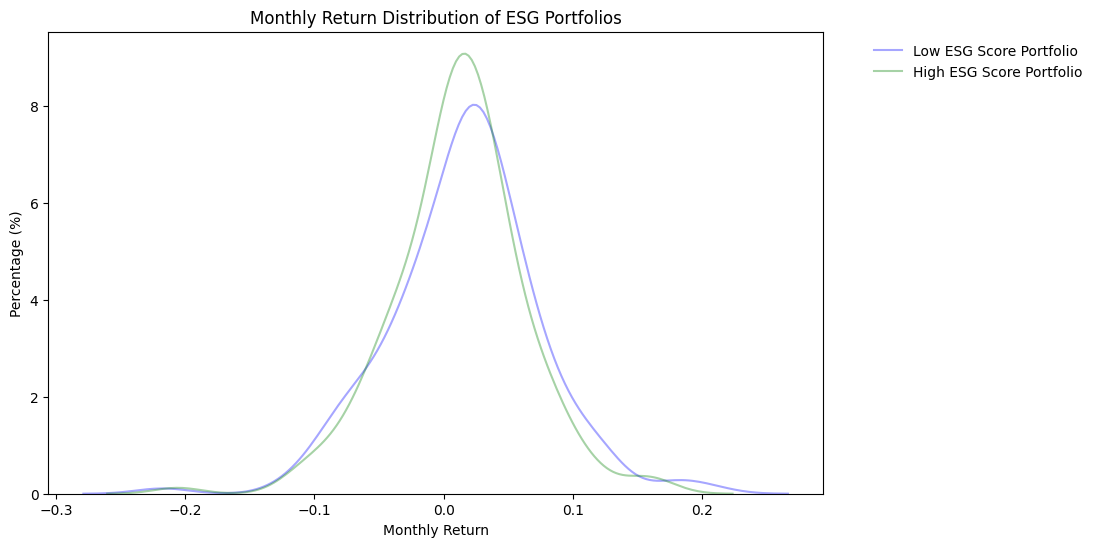

In [25]:
data_list = [data, data]
column_names = ["return_low_esg", "return_high_esg"]
labels = ["Low ESG Score Portfolio", "High ESG Score Portfolio"]
colors = ["blue", "green"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of ESG Portfolios",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**Residual Momentum Factor**

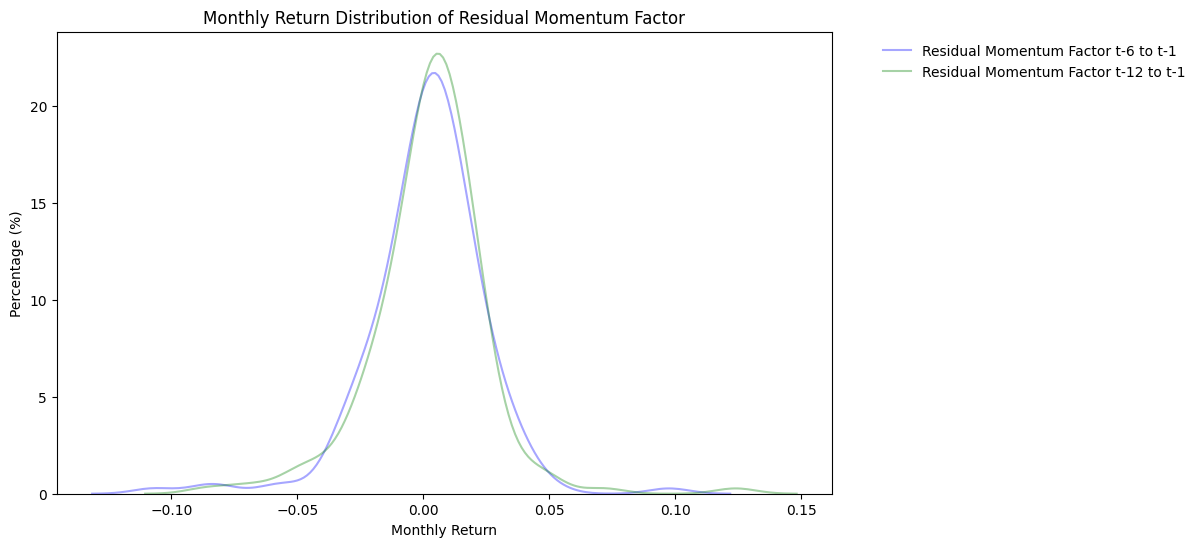

In [28]:
data_list = [data, data]
column_names = ["Mom_Res_6_1_Factor", "Mom_Res_12_1_Factor"]
labels = ["Residual Momentum Factor t-6 to t-1", "Residual Momentum Factor t-12 to t-1"]
colors = ["blue", "green"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of Residual Momentum Factor",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**Price Momentum Factor**

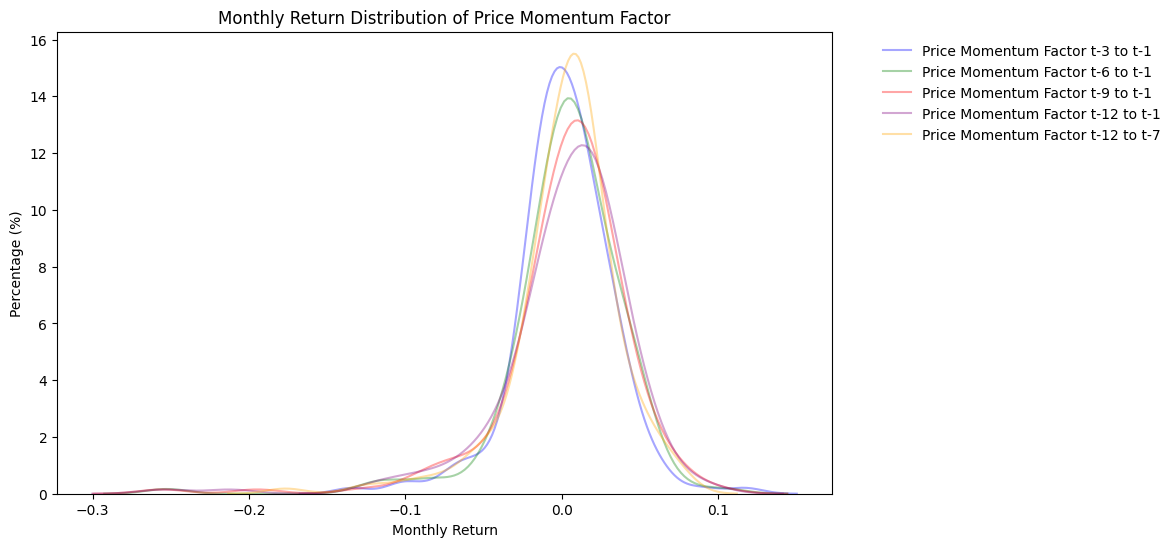

In [30]:
data_list = [data, data, data, data, data]

column_names = ["Mom_Price_3_1_Factor",
                "Mom_Price_6_1_Factor",
                "Mom_Price_9_1_Factor",
                "Mom_Price_12_1_Factor",
                "Mom_Price_12_7_Factor"]

labels = ["Price Momentum Factor t-3 to t-1",
          "Price Momentum Factor t-6 to t-1",
          "Price Momentum Factor t-9 to t-1",
          "Price Momentum Factor t-12 to t-1",
          "Price Momentum Factor t-12 to t-7"]

colors = ["blue", "green", "red", "purple", "orange"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of Price Momentum Factor",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**Fama French 5 Factors**

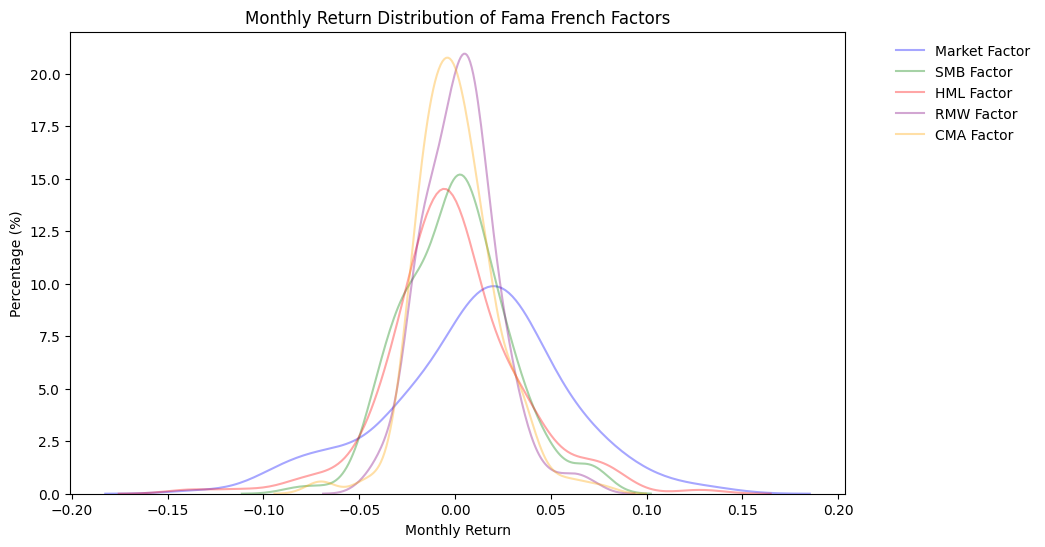

In [31]:
data_list = [data, data, data, data, data]

column_names = ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]
labels = ["Market Factor", "SMB Factor", "HML Factor", "RMW Factor", "CMA Factor"]
colors = ["blue", "green", "red", "purple", "orange"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of Fama French Factors",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

### **2.2 Returns over Time**

In [32]:
def plotXReturnsOverTime(data_list, column_names, labels, title, x_label, y_label):

  plt.figure(figsize=(10, 6), dpi=100)

  for i in range(len(column_names)):
    data = data_list[i]
    column_name = column_names[i]

    sns.lineplot(data = data, x = "Date", y = column_name, label = labels[i])

  # Add labels and title
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Add legend
  plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

  # Remove Grid
  plt.grid(visible = False)

  # Show plot
  plt.show()

**ESG Factor**

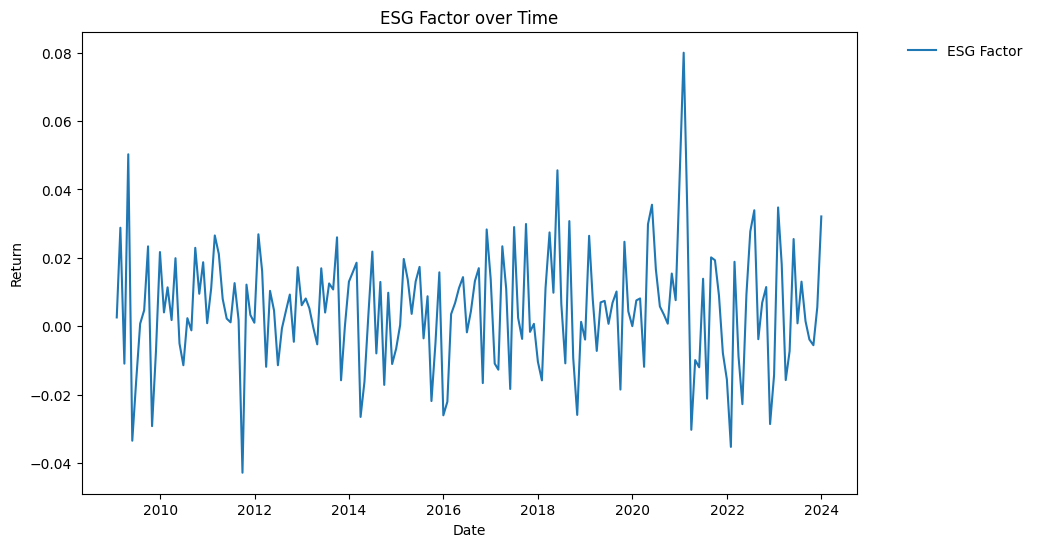

In [33]:
data_list = [data]
column_names = ["ESG_Factor"]
labels = ["ESG Factor"]

plotXReturnsOverTime(data_list, column_names, labels, "ESG Factor over Time", "Date", "Return")

**Momentum Factor**

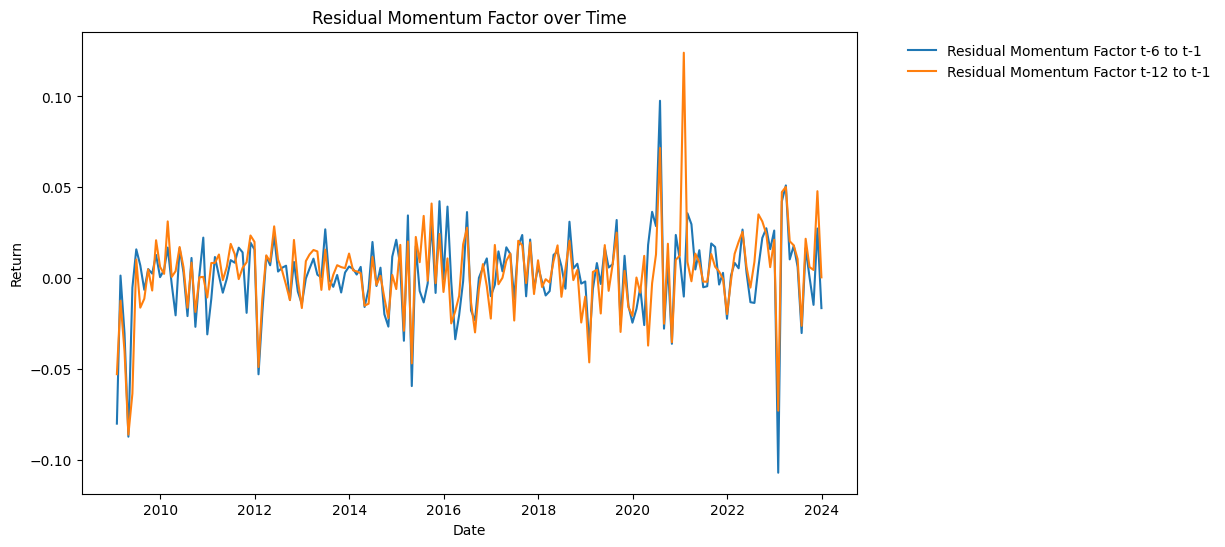

In [34]:
data_list = [data, data]
column_names = ["Mom_Res_6_1_Factor", "Mom_Res_12_1_Factor"]
labels = ["Residual Momentum Factor t-6 to t-1", "Residual Momentum Factor t-12 to t-1"]

plotXReturnsOverTime(data_list, column_names, labels, "Residual Momentum Factor over Time", "Date", "Return")

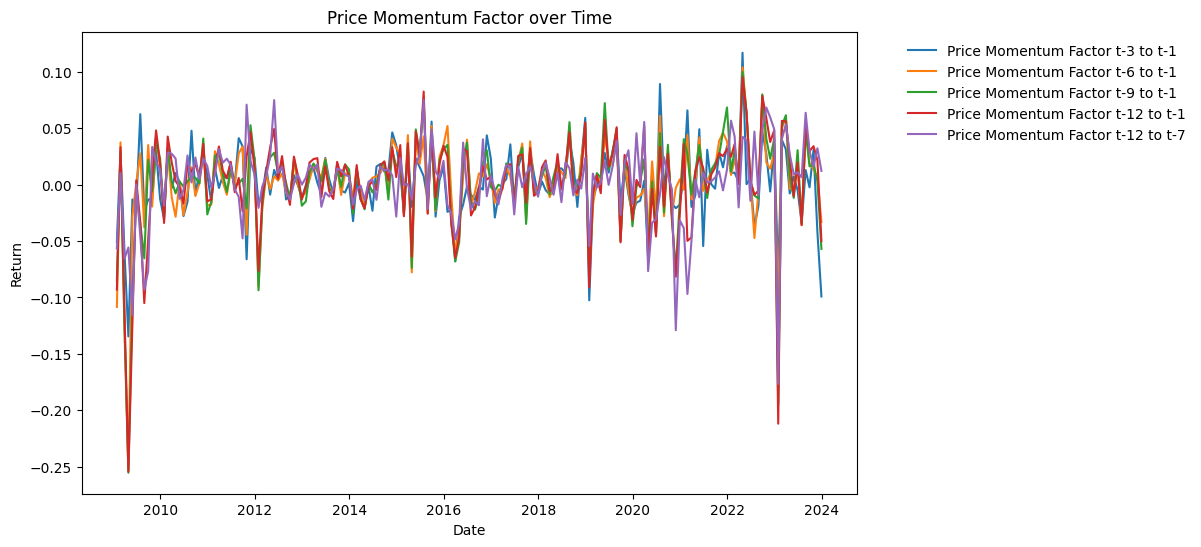

In [35]:
data_list = [data, data, data, data, data]

column_names = ["Mom_Price_3_1_Factor",
                "Mom_Price_6_1_Factor",
                "Mom_Price_9_1_Factor",
                "Mom_Price_12_1_Factor",
                "Mom_Price_12_7_Factor"]

labels = ["Price Momentum Factor t-3 to t-1",
          "Price Momentum Factor t-6 to t-1",
          "Price Momentum Factor t-9 to t-1",
          "Price Momentum Factor t-12 to t-1",
          "Price Momentum Factor t-12 to t-7"]

plotXReturnsOverTime(data_list, column_names, labels, "Price Momentum Factor over Time", "Date", "Return")

**Momentum & ESG Factor**

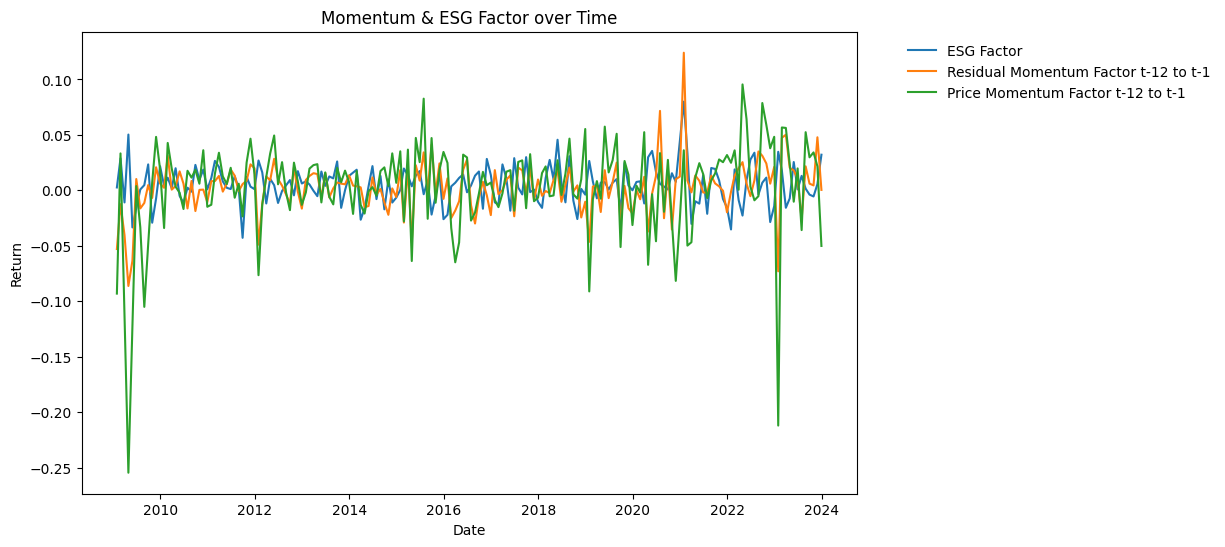

In [36]:
data_list = [data, data, data]
column_names = ["ESG_Factor", "Mom_Res_12_1_Factor", "Mom_Price_12_1_Factor"]
labels = ["ESG Factor", "Residual Momentum Factor t-12 to t-1", "Price Momentum Factor t-12 to t-1"]

plotXReturnsOverTime(data_list, column_names, labels, "Momentum & ESG Factor over Time", "Date", "Return")


## **3. Fama-Macbeth Regression to Determine Risk Premiums for Factors and Visualize Correlation with Heatmap**

### **3.1 Run Regressions**

In [37]:
#Copy Data for Regression to prevent altering original Data
regression_data = data.copy()

In [50]:
momentum_factor_columns = ["Mom_Res_12_1_Factor",
                           "Mom_Res_6_1_Factor",
                           "Mom_Price_3_1_Factor",
                           "Mom_Price_6_1_Factor",
                           "Mom_Price_9_1_Factor",
                           "Mom_Price_12_1_Factor",
                           "Mom_Price_12_7_Factor"]

models_betas = []

**First Stage: Extended Fama-French Regression**

In [51]:
for i in range(len(momentum_factor_columns)):

  factor_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "ESG_Factor"] + [momentum_factor_columns[i]]
  other_not_needed_columns = ["return_high_esg", "return_low_esg", "Date"] + momentum_factor_columns[:i] + momentum_factor_columns[i+1:]

  stocks = [col for col in regression_data.columns if col not in (factor_columns + ["RF"] + other_not_needed_columns)]
  betas = pd.DataFrame(columns=["Stock", "Intercept"] + factor_columns)

  #Run Regression
  for stock in stocks:

    #Drop missing values
    current_stock_data = regression_data[["RF"] + factor_columns + [stock]].dropna()

    #Make sure regression is only done if there are at least 32 data-points.
    if len(current_stock_data) >= 32:

      Y = current_stock_data[stock] - current_stock_data["RF"] #Computes Excess Return
      X = current_stock_data[factor_columns] #Sets Factors
      X = sm.add_constant(X) #Adds constant to model

      model = sm.OLS(Y, X).fit() #Runs regression

      coefficients = model.params #Gets betas
      row = [stock] + coefficients.tolist()

      betas.loc[len(betas)] = row #Add betas

  models_betas.append(betas)

In [55]:
for i in range(len(models_betas)):
  print(f"OLS Model {i + 1} ran for {len(models_betas[i])} stocks!")

OLS Model 1 ran for 1441 stocks!
OLS Model 2 ran for 1441 stocks!
OLS Model 3 ran for 1441 stocks!
OLS Model 4 ran for 1441 stocks!
OLS Model 5 ran for 1441 stocks!
OLS Model 6 ran for 1441 stocks!
OLS Model 7 ran for 1441 stocks!


In [57]:
models_betas[0].head()

,Stock,Intercept,Mkt-RF,SMB,HML,RMW,CMA,ESG_Factor,Mom_Res_12_1_Factor
0,A.N,0.005362,1.272793,0.202076,-0.335590,-0.395972,0.409314,-0.343662,-0.155283
1,AA.N,0.028505,1.896007,3.677223,0.407005,0.443991,-0.112176,-4.284922,0.186213
2,AAL.OQ,0.002894,1.266497,1.769475,0.470233,-0.123773,-0.439936,-1.917636,0.188798
3,AAON.OQ,0.009646,0.886744,0.909696,0.025966,0.100442,-0.273057,-0.344243,0.629351
4,AAP.N,-0.004740,0.708906,0.682082,-0.121997,1.028306,0.794547,0.359256,-0.410240


**Second Stage: Regress Average Stock Excess Return on betas**

In [58]:
#Calculate average excess return
average_excess_returns = {
    stock: (data[stock] - data["RF"]).mean()
    for stock in stocks
}

#Create a dataframe with average excess returns
average_excess_df = pd.DataFrame(list(average_excess_returns.items()), columns=["Stock", "Avg_Excess_Return"])

#Merge with betas table

stage_2_dataframes = []

for i in range(len(models_betas)):

  stage_2_data = models_betas[i].merge(average_excess_df, on = "Stock")
  stage_2_dataframes.append(stage_2_data)

In [62]:
stage_2_dataframes[0].head()

,Stock,Intercept,Mkt-RF,SMB,HML,RMW,CMA,ESG_Factor,Mom_Res_12_1_Factor,Avg_Excess_Return
0,A.N,0.005362,1.272793,0.202076,-0.335590,-0.395972,0.409314,-0.343662,-0.155283,0.017228
1,AA.N,0.028505,1.896007,3.677223,0.407005,0.443991,-0.112176,-4.284922,0.186213,0.020151
2,AAL.OQ,0.002894,1.266497,1.769475,0.470233,-0.123773,-0.439936,-1.917636,0.188798,0.002053
3,AAON.OQ,0.009646,0.886744,0.909696,0.025966,0.100442,-0.273057,-0.344243,0.629351,0.019831
4,AAP.N,-0.004740,0.708906,0.682082,-0.121997,1.028306,0.794547,0.359256,-0.410240,0.007799


In [64]:
risk_premium_estimations = []

for i in range(len(stage_2_dataframes)):

  stage_2_data = stage_2_dataframes[i]

  stage_2_factor_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "ESG_Factor"] + [momentum_factor_columns[i]]

  stage_2_Y = stage_2_data["Avg_Excess_Return"] #Computes Excess Return
  stage_2_X = stage_2_data[stage_2_factor_columns]
  stage_2_X = sm.add_constant(stage_2_X) #Adds constant to model

  stage_2_model = sm.OLS(stage_2_Y, stage_2_X).fit(cov_type='HC3') #Runs regression with Heteroskedasticity robust std. errors

  risk_premia = stage_2_model.params
  p_values = stage_2_model.pvalues

  risk_premia_data = pd.DataFrame({
      "Risk Premium (%)": round(risk_premia * 100, 4),
      "P-value": round(p_values, 4)
  })

  risk_premium_estimations.append(risk_premia_data)

In [69]:
risk_premium_estimations[0].head(10)

,Risk Premium (%),P-value
const,0.5881,0.0000
Mkt-RF,0.9377,0.0000
SMB,0.1949,0.0016
HML,-0.5146,0.0000
RMW,-0.1735,0.0026
CMA,-0.3999,0.0000
ESG_Factor,0.3052,0.0000
Mom_Res_12_1_Factor,0.1962,0.1073


In [70]:
risk_premium_estimations[1].head(10)

,Risk Premium (%),P-value
const,0.6384,0.0000
Mkt-RF,0.8538,0.0000
SMB,0.2551,0.0075
HML,-0.4972,0.0000
RMW,-0.2235,0.0107
CMA,-0.3222,0.0110
ESG_Factor,0.3663,0.0001
Mom_Res_6_1_Factor,0.1623,0.0480


In [71]:
risk_premium_estimations[2].head(10)

,Risk Premium (%),P-value
const,0.5617,0.0000
Mkt-RF,0.9416,0.0000
SMB,0.2208,0.0091
HML,-0.5016,0.0000
RMW,-0.2098,0.0047
CMA,-0.3140,0.0051
ESG_Factor,0.3564,0.0000
Mom_Price_3_1_Factor,0.0166,0.8791


In [72]:
risk_premium_estimations[3].head(10)

,Risk Premium (%),P-value
const,0.5905,0.0000
Mkt-RF,0.9096,0.0000
SMB,0.2298,0.0104
HML,-0.5114,0.0000
RMW,-0.2240,0.0063
CMA,-0.3112,0.0092
ESG_Factor,0.3532,0.0001
Mom_Price_6_1_Factor,-0.1153,0.2930


In [73]:
risk_premium_estimations[4].head(10)

,Risk Premium (%),P-value
const,0.5512,0.0000
Mkt-RF,0.9453,0.0000
SMB,0.2379,0.0071
HML,-0.5191,0.0000
RMW,-0.2190,0.0054
CMA,-0.3167,0.0074
ESG_Factor,0.3485,0.0001
Mom_Price_9_1_Factor,-0.0938,0.4883


In [74]:
risk_premium_estimations[5].head(10)

,Risk Premium (%),P-value
const,0.5663,0.0000
Mkt-RF,0.9289,0.0000
SMB,0.2382,0.0077
HML,-0.5284,0.0000
RMW,-0.2274,0.0045
CMA,-0.3183,0.0075
ESG_Factor,0.3512,0.0001
Mom_Price_12_1_Factor,-0.1141,0.4175


In [75]:
risk_premium_estimations[6].head(10)

,Risk Premium (%),P-value
const,0.6702,0.0000
Mkt-RF,0.8336,0.0000
SMB,0.2184,0.0131
HML,-0.5522,0.0000
RMW,-0.2391,0.0024
CMA,-0.3482,0.0012
ESG_Factor,0.3504,0.0000
Mom_Price_12_7_Factor,-0.2674,0.0093


### **3.2 Calculate & Plot Pearson Correlation Coefficient**

In [44]:
def plotHeatmap(corr_matrix, title):
  plt.figure(figsize=(12, 10))

  #Plot Heatmap
  sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0, fmt='.2f')

  # Move x-axis to top
  plt.gca().xaxis.set_ticks_position('top')
  plt.gca().xaxis.set_label_position('top')

  #Rotate labels on X-Axis
  plt.xticks(rotation = 60)

  #Add title
  plt.title(title)
  plt.show()

In [42]:
#Calculating Correlation Coefficients

momentum_factor_columns = ["Mom_Res_12_1_Factor",
                           "Mom_Res_6_1_Factor",
                           "Mom_Price_3_1_Factor",
                           "Mom_Price_6_1_Factor",
                           "Mom_Price_9_1_Factor",
                           "Mom_Price_12_1_Factor",
                           "Mom_Price_12_7_Factor"]

factor_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "ESG_Factor"] + momentum_factor_columns

corr_matrix = regression_data[factor_columns].corr()

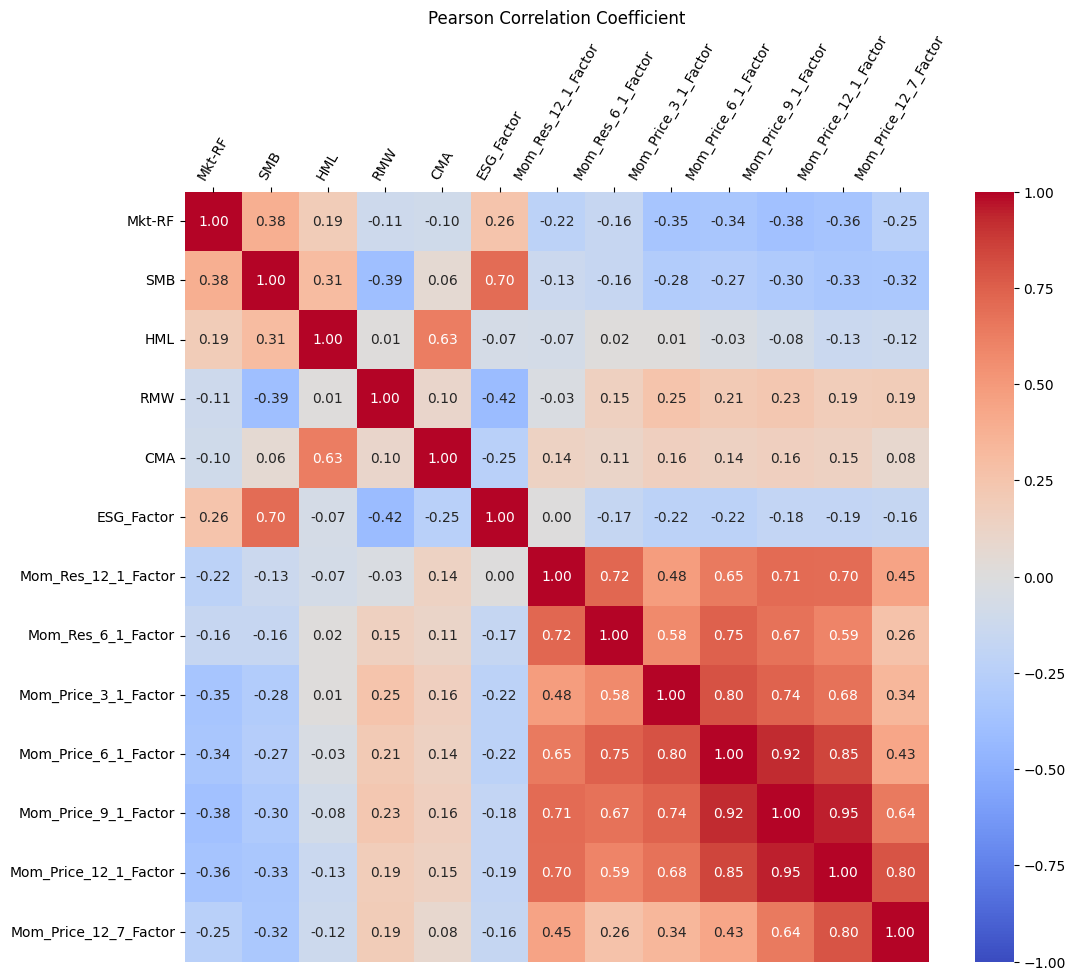

In [45]:
plotHeatmap(corr_matrix, "Pearson Correlation Coefficient")

### **3.2 Calculate & Plot Spearman Rank Correlation**

In [46]:
#Subset Data to only look at wanted columns
spearman_rank_data = regression_data[factor_columns].copy()

#Calculate Rank Correlation
spearman_corr = spearman_rank_data.corr(method = 'spearman')

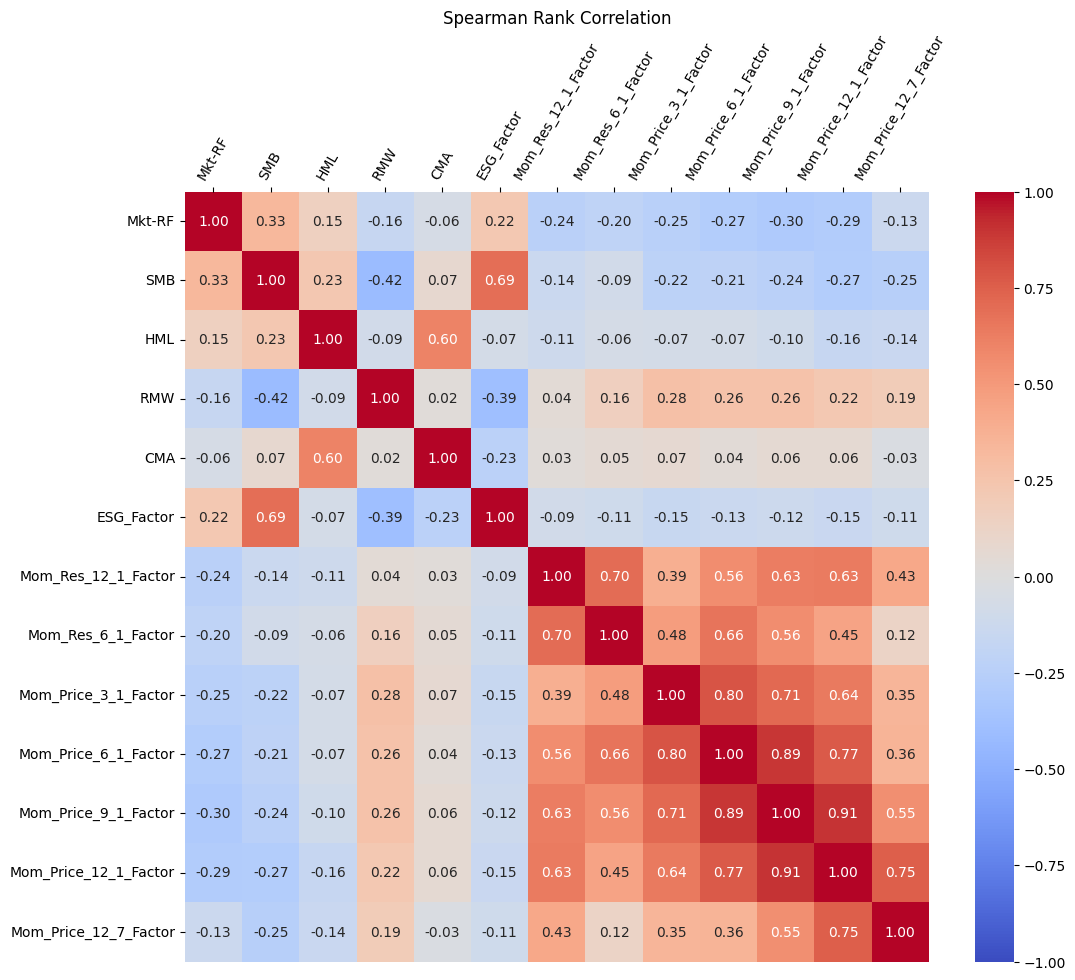

In [47]:
plotHeatmap(spearman_corr, "Spearman Rank Correlation")

### **3.3 Calculate & Plot Kendall Tau**

In [48]:
n_cols = len(factor_columns)

#Initialize empty matrix
kendall_corr_matrix = np.zeros((n_cols, n_cols))

#Counting variable for rows
row = 0

#Loop over all coefficients
for factor_1 in factor_columns:

  #Counting variable for column
  column = 0

  #Loop over all coefficients again
  for factor_2 in factor_columns:

    #Calculate Kendall Tau Correlation
    tau, _ = kendalltau(regression_data[factor_1], regression_data[factor_2])
    kendall_corr_matrix[row, column] = tau

    column = column + 1

  row = row + 1

#Convert to a DataFrame for easier plotting
kendall_tau_df = pd.DataFrame(kendall_corr_matrix, columns = factor_columns, index = factor_columns)

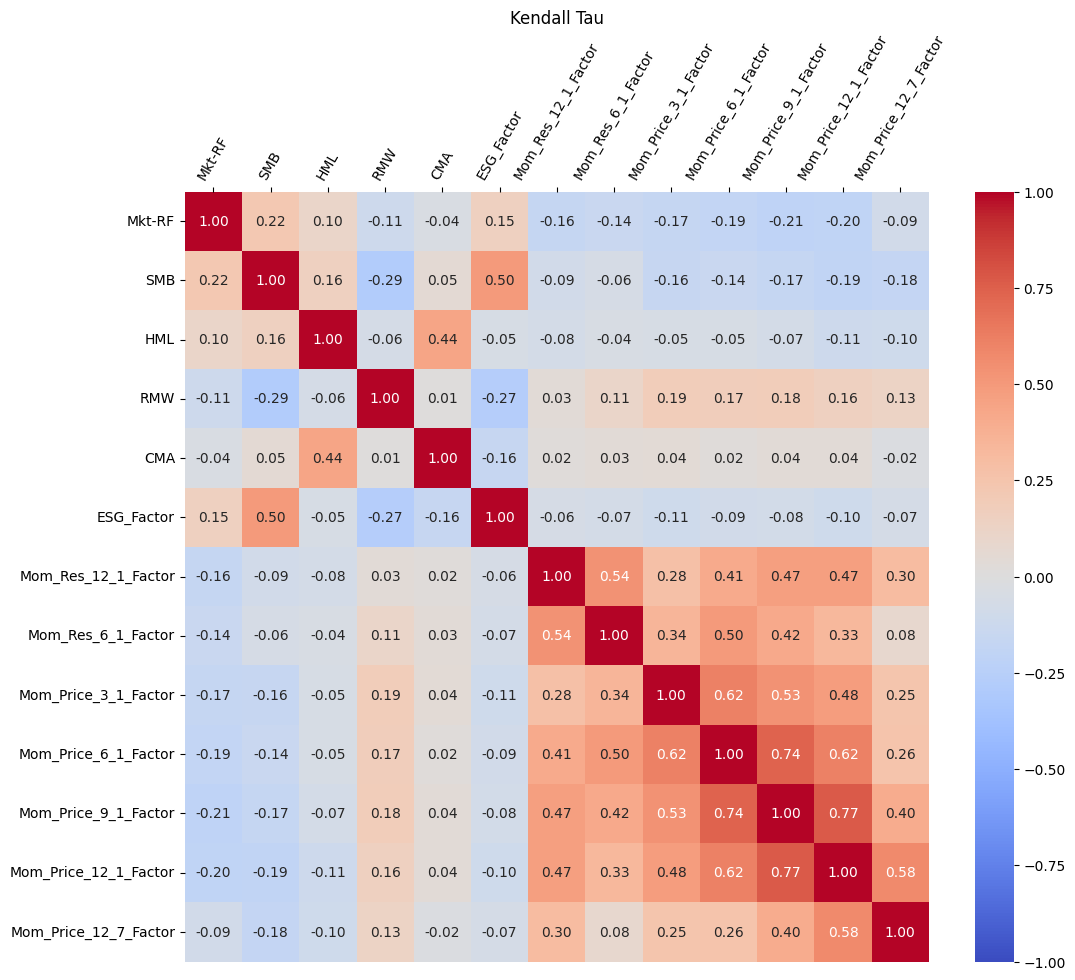

In [49]:
plotHeatmap(kendall_tau_df, "Kendall Tau") #rank-based relationships

## **4. Performance Metrics ESG Portfolios**

In [187]:
#Returns Risk Free Ratio (Averatge):
def getRiskFreeRate(data):
  return data["RF"].mean()

In [188]:
#Returns Average Return
def getAverageReturn(data, column):
  return data[column].mean() #Average Return

In [189]:
#Return Standard Deviation
def getStdDev(data, column):
  return data[column].std()

In [190]:
#Returns Annualized Return
def getAnnualizedReturn(data, column):
  avg_return = getAverageReturn(data, column)
  return (1 + avg_return) ** 12 - 1

In [191]:
#Returns Annualized Volatility
def getAnnualizedVolatility(data, column):
  std_return = getStdDev(data, column)
  return std_return * np.sqrt(12) #Assuming Monthly Data

In [192]:
#Returns Sharpe Ratio
def getSharpeRatio(data, column):

  average_return = getAverageReturn(data, column)
  std_dev = getStdDev(data, column)

  return (average_return - getRiskFreeRate(data)) / std_dev if std_dev != 0 else np.nan

In [193]:
#Returns Sortino Ratio
def getSortinoRatio(data, column):
  downside_returns = data[column][data[column] < 0]
  downside_deviation = np.sqrt((downside_returns**2).mean())

  average_return = getAverageReturn(data, column)

  return (average_return - getRiskFreeRate(data)) / downside_deviation if downside_deviation != 0 else np.nan


In [194]:
#Returns TreynorRatio
def getTreynorRatio(data, column):

  annualized_return = getAnnualizedReturn(data, column)
  market_return = data["Mkt-RF"].mean()

  X = sm.add_constant(data["Mkt-RF"])
  model = sm.OLS(data[column], X).fit()

  #Risk is here not the Std. Dev but beta
  beta = model.params[1]

  return (annualized_return - getRiskFreeRate(data)) / beta if beta != 0 else np.nan


In [195]:
#Returns Alpha
def getAlpha(data, column):
  market_return = data["Mkt-RF"].mean()

  X = sm.add_constant(data["Mkt-RF"])
  model = sm.OLS(data[column], X).fit()

  return model.params[0]

In [196]:
#Returns Information Ratio
def getInformationRatio(data, column):

  tracking_error = np.sqrt(((((data[column] - data["RF"]) - data["Mkt-RF"])).dropna())**2).mean()
  average_return = getAverageReturn(data, column)

  return (average_return - data["Mkt-RF"].mean()) / tracking_error if tracking_error != 0 else np.nan

In [197]:
#Returns M2 Measure (Modigliani Measure)
def getM2Measure(data, column):
  market_volatility = data["Mkt-RF"].std()
  return (getSharpeRatio(data, column) * market_volatility) + getRiskFreeRate(data)

In [198]:
round_decimals = 4

def calculatePerformanceMetrics(data, column):
  print(f"\nPerformance Metrics for {column}:")
  print(f"1. Annualized Return: {round(getAnnualizedReturn(data, column), round_decimals)}")
  print(f"2. Annualized Volatility: {round(getAnnualizedVolatility(data, column), round_decimals)}")
  print(f"3. Sharpe Ratio: {round(getSharpeRatio(data, column), round_decimals)}")
  print(f"4. Sortino Ratio: {round(getSortinoRatio(data, column), round_decimals)}")
  print(f"5. Treynor Ratio: {round(getTreynorRatio(data, column), round_decimals)}")
  print(f"6. Alpha: {round(getAlpha(data, column), round_decimals)}")
  print(f"7. Information Ratio: {round(getInformationRatio(data, column), round_decimals)}")
  print(f"8. M2 Measure: {round(getM2Measure(data, column), round_decimals)}")

In [199]:
portfolios = ['low_esg', 'high_esg']

metrics = [calculatePerformanceMetrics(regression_data, f"return_{portfolio}") for portfolio in portfolios]
metrics


Performance Metrics for return_low_esg:
1. Annualized Return: 0.2131
2. Annualized Volatility: 0.1995
3. Sharpe Ratio: 0.2703
4. Sortino Ratio: 0.2741
5. Treynor Ratio: 0.181
6. Alpha: 0.0029
7. Information Ratio: 0.3098
8. M2 Measure: 0.0131

Performance Metrics for return_high_esg:
1. Annualized Return: 0.1411
2. Annualized Volatility: 0.1779
3. Sharpe Ratio: 0.2023
4. Sortino Ratio: 0.1919
5. Treynor Ratio: 0.1304
6. Alpha: -0.0011
7. Information Ratio: -0.0268
8. M2 Measure: 0.0099


[None, None]